In [190]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from typing import Tuple

# from isaaclab.utils import configclass

In [191]:
# @configclass
class Material3DRFTCfg:
    """
    See https://www.pnas.org/doi/10.1073/pnas.2214017120 supplementary material S3. 
    """
    # c1^k
    c1_1: float = 0.00212
    c1_2: float = -0.02320
    c1_3: float = -0.20890
    c1_4: float = -0.43083
    c1_5: float = -0.00259
    c1_6: float = 0.48872
    c1_7: float = -0.00415
    c1_8: float = 0.07204
    c1_9: float = -0.02750
    c1_10: float = -0.08772
    c1_11: float = 0.01992
    c1_12: float = -0.45961
    c1_13: float = 0.40799
    c1_14: float = -0.10107
    c1_15: float = -0.06576
    c1_16: float = 0.05664
    c1_17: float = -0.09269
    c1_18: float = 0.01892
    c1_19: float = 0.01033
    c1_20: float = 0.15120

    # c2^k
    c2_1: float = -0.06796
    c2_2: float = -0.10941
    c2_3: float = 0.04725
    c2_4: float = -0.06914
    c2_5: float = -0.05835
    c2_6: float = -0.65880
    c2_7: float = -0.11985
    c2_8: float = -0.25739
    c2_9: float = -0.26834
    c2_10: float = 0.02692
    c2_11: float = -0.00736
    c2_12: float = 0.63758
    c2_13: float = 0.08997
    c2_14: float = 0.21069
    c2_15: float = 0.04748
    c2_16: float = 0.20406
    c2_17: float = 0.18519
    c2_18: float = 0.04934
    c2_19: float = 0.13527
    c2_20: float = -0.33207

    # c3^k
    c3_1: float = -0.02634
    c3_2: float = -0.03436
    c3_3: float = 0.45256
    c3_4: float = 0.00835
    c3_5: float = 0.02553
    c3_6: float = -1.31290
    c3_7: float = -0.05532
    c3_8: float = 0.06790
    c3_9: float = -0.16404
    c3_10: float = 0.02287
    c3_11: float = 0.02927
    c3_12: float = 0.95406
    c3_13: float = -0.00131
    c3_14: float = -0.11028
    c3_15: float = 0.01487
    c3_16: float = -0.20770
    c3_17: float = 0.10911
    c3_18: float = -0.04097
    c3_19: float = 0.07881
    c3_20: float = -0.27519

    stiffness: float = 1.0
    static_friction_coef: float = 1.0
    dynamic_friction_coef: float = 0.15
    mu_int: float = 0.4

### elementary force computation 

In [192]:
def compute_elementary_force(cfg:Material3DRFTCfg, beta:torch.Tensor, gamma:torch.Tensor, psi: torch.Tensor):
    """
    Compute elementary force per foot using Fourier series expansion. 
    See the original paper. 
    
    Args: 
        beta: intrusion angle (pitch) of contact point. (batch_size,)
        gamma: intrusion direction angle of contact point. (batch_size,)
        psi: azimuth angle of contact point. (batch_size,)
    """
    p1 = torch.sin(gamma)
    p2 = torch.cos(beta)
    p3 = torch.cos(psi)*torch.cos(gamma)*torch.sin(beta) + torch.sin(gamma)*torch.cos(beta)
    
    base = [torch.ones_like(p1), p1, p2, p3, p1**2, p2**2, p3**2, p1*p2, p2*p3, p3*p1, p1**3, p2**3, p3**3, p1*(p2)**2, p2*(p1)**2, p2*(p3)**2, p3*(p2)**2, p3*(p1)**2, p1*(p3)**2, p1*p2*p3]
    coef_1 = [cfg.c1_1, cfg.c1_2, cfg.c1_3, cfg.c1_4, cfg.c1_5, cfg.c1_6, cfg.c1_7, cfg.c1_8, cfg.c1_9, cfg.c1_10,
                cfg.c1_11, cfg.c1_12, cfg.c1_13, cfg.c1_14, cfg.c1_15, cfg.c1_16, cfg.c1_17, cfg.c1_18, cfg.c1_19, cfg.c1_20]
    coef_2 = [cfg.c2_1, cfg.c2_2, cfg.c2_3, cfg.c2_4, cfg.c2_5, cfg.c2_6, cfg.c2_7, cfg.c2_8, cfg.c2_9, cfg.c2_10,
                cfg.c2_11, cfg.c2_12, cfg.c2_13, cfg.c2_14, cfg.c2_15, cfg.c2_16, cfg.c2_17, cfg.c2_18, cfg.c2_19, cfg.c2_20]
    coef_3 = [cfg.c3_1, cfg.c3_2, cfg.c3_3, cfg.c3_4, cfg.c3_5, cfg.c3_6, cfg.c3_7, cfg.c3_8, cfg.c3_9, cfg.c3_10,
                cfg.c3_11, cfg.c3_12, cfg.c3_13, cfg.c3_14, cfg.c3_15, cfg.c3_16, cfg.c3_17, cfg.c3_18, cfg.c3_19, cfg.c3_20]

    f1 = torch.stack([coef_1[i] * base[i] for i in range(20)]).sum(dim=0)
    f2 = torch.stack([coef_2[i] * base[i] for i in range(20)]).sum(dim=0)
    f3 = torch.stack([coef_3[i] * base[i] for i in range(20)]).sum(dim=0)
    
    alpha_gen_r = f1 * torch.sin(beta) * torch.cos(psi) + f2 * torch.cos(gamma)
    alpha_gen_t = f1 * torch.sin(beta) * torch.sin(psi)
    alpha_gen_z = -f1 * torch.cos(beta) - f2 * torch.sin(gamma) - f3

    # alpha_gen in {r, t, z} system
    alpha_gen = torch.cat([
        alpha_gen_r.unsqueeze(-1), 
        alpha_gen_t.unsqueeze(-1), 
        alpha_gen_z.unsqueeze(-1)], dim=-1) # (batch_size, 3)

    rho_c = 3000 # kg/m^3
    g = 9.81 # m/s^2
    mu_int = cfg.mu_int
    xi = rho_c * g * (894 * (mu_int **3) - 386 * (mu_int **2) + 89 * mu_int) # N/m^3

    alpha = xi * alpha_gen # alpha_gen -> alpha by multiplying media specific params

    # norm vector in {r, t, z} system
    n = torch.cat([
        (torch.sin(beta)*torch.cos(psi)).unsqueeze(-1),
        (torch.sin(beta)*torch.sin(psi)).unsqueeze(-1),
        -(torch.cos(beta)).unsqueeze(-1)
    ], dim=-1)

    # retrieve normal and tangential components of alpha.
    alpha_n = (alpha * n).sum(dim=-1, keepdim=True) * (n) # normal component
    alpha_n_norm = torch.norm(alpha_n, dim=-1)
    alpha_tan = alpha - alpha_n
    alpha_tan_norm = torch.norm(alpha_tan, dim=-1)

    # enforce friction cone
    cone_coef = torch.minimum(torch.ones_like(alpha_tan_norm), (cfg.dynamic_friction_coef * alpha_n_norm) / (alpha_tan_norm + 1e-6)).unsqueeze(-1)
    alpha = alpha_n + cone_coef * alpha_tan
    
    alpha_gen_r = alpha[:, 0]/xi
    alpha_gen_t = alpha[:, 1]/xi
    alpha_gen_z = alpha[:, 2]/xi

    return -alpha_gen_r, alpha_gen_t, alpha_gen_z

In [193]:
N = 30
beta_space = torch.linspace(-torch.pi/2, torch.pi/2, N)
gamma_space = torch.linspace(-torch.pi/2, torch.pi/2, N)
psi_space = torch.linspace(0, torch.pi/2, 4)

beta_grid, gamma_grid = torch.meshgrid(beta_space, gamma_space, indexing='ij')
beta = beta_grid.reshape(-1)
gamma = gamma_grid.reshape(-1)

M = len(psi_space)
beta = beta.reshape(N, N).flip(dims=[0]).reshape(-1).unsqueeze(-1).repeat(M, 1).reshape(-1)
gamma = gamma.reshape(N, N).reshape(-1).unsqueeze(-1).repeat(M, 1).reshape(-1)
psi = torch.stack([s * torch.ones(N*N) for s in psi_space], dim=0).reshape(-1)


alpha_r, alpha_t, alpha_z = compute_elementary_force(Material3DRFTCfg(), beta, gamma, psi)
alpha_r_vis = alpha_r.reshape(M, N, N)
alpha_t_vis = alpha_t.reshape(M, N, N)
alpha_z_vis = alpha_z.reshape(M, N, N)

### Resistive force triplet $\alpha_r, \alpha_{\theta}, \alpha_z$

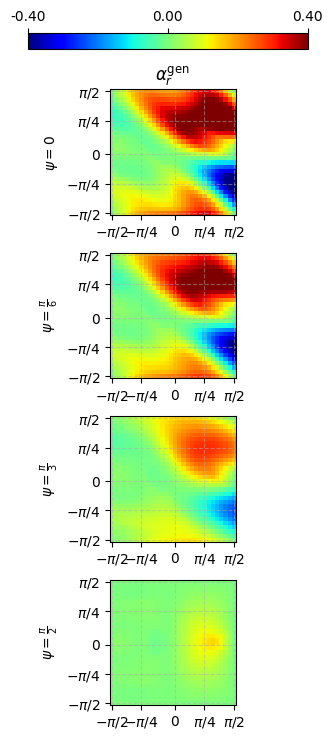

In [230]:
fig, axs = plt.subplots(M, 1, figsize=(4, 8))

vmin, vmax = -0.4, 0.4


# alpha_r
ax = axs[0]
ax.imshow(alpha_r_vis[0], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_title(r"$\alpha_r^\text{gen}$")
ax.set_ylabel(r'$\psi=0$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[1]
ax.imshow(alpha_r_vis[1], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{6}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[2]
ax.imshow(alpha_r_vis[2], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{3}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[3]
ax.imshow(alpha_r_vis[3], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{2}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

# adjust layout before adding colorbar
fig.subplots_adjust(top=0.88, hspace=0.3)

# create custom colorbar axis at the top
cbar_ax = fig.add_axes((0.15, 0.93, 0.7, 0.02))  # [left, bottom, width, height]
cbar = fig.colorbar(axs[0].images[0], cax=cbar_ax, orientation='horizontal')

# set ticks and labels
num_color_bin = 3
cbar.set_ticks(np.linspace(vmin, vmax, num_color_bin).tolist())
cbar.set_ticklabels([f"{v:.2f}" for v in np.linspace(vmin, vmax, num_color_bin)])
cbar.ax.tick_params(labelsize=10, top=True, labeltop=True, bottom=False, labelbottom=False)

plt.savefig("alpha_r_gen.png", dpi=300)
plt.show()

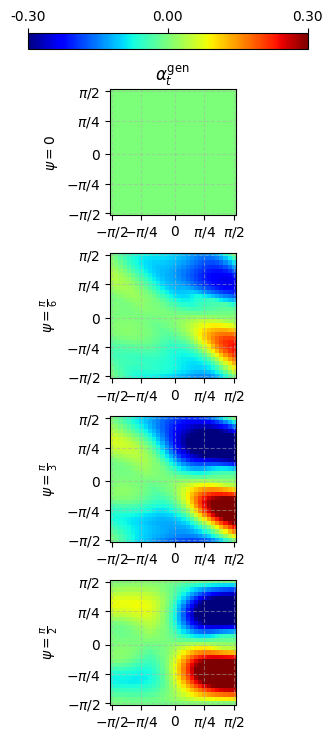

In [231]:
fig, axs = plt.subplots(M, 1, figsize=(4, 8))

vmin, vmax = -0.3, 0.3


# alpha_r
ax = axs[0]
ax.imshow(alpha_t_vis[0], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_title(r"$\alpha_t^\text{gen}$")
ax.set_ylabel(r'$\psi=0$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[1]
ax.imshow(alpha_t_vis[1], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{6}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[2]
ax.imshow(alpha_t_vis[2], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{3}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[3]
ax.imshow(alpha_t_vis[3], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{2}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

# adjust layout before adding colorbar
fig.subplots_adjust(top=0.88, hspace=0.3)

# create custom colorbar axis at the top
cbar_ax = fig.add_axes((0.15, 0.93, 0.7, 0.02))  # [left, bottom, width, height]
cbar = fig.colorbar(axs[0].images[0], cax=cbar_ax, orientation='horizontal')

# set ticks and labels
num_color_bin = 3
cbar.set_ticks(np.linspace(vmin, vmax, num_color_bin).tolist())
cbar.set_ticklabels([f"{v:.2f}" for v in np.linspace(vmin, vmax, num_color_bin)])
cbar.ax.tick_params(labelsize=10, top=True, labeltop=True, bottom=False, labelbottom=False)

plt.savefig("alpha_t_gen.png", dpi=300)
plt.show()

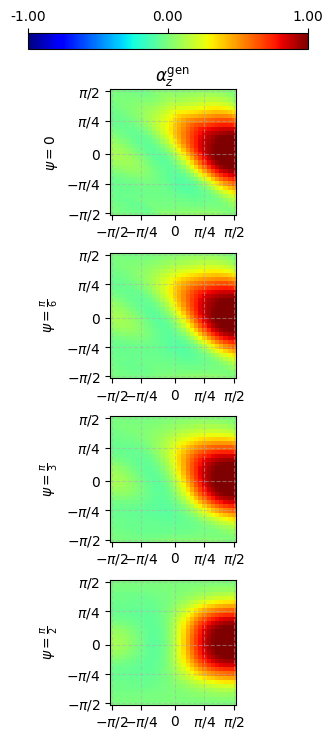

In [232]:
fig, axs = plt.subplots(M, 1, figsize=(4, 8))

vmin, vmax = -1.0, 1.0


# alpha_r
ax = axs[0]
ax.imshow(alpha_z_vis[0], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_title(r"$\alpha_z^\text{gen}$")
ax.set_ylabel(r'$\psi=0$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[1]
ax.imshow(alpha_z_vis[1], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{6}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[2]
ax.imshow(alpha_z_vis[2], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{3}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])

ax = axs[3]
ax.imshow(alpha_z_vis[3], cmap='jet', vmin=vmin, vmax=vmax)
ax.set_ylabel(r'$\psi=\frac{\pi}{2}$')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xticks([0, N//4, N//2, 3*N//4, N-1], [r"$-\pi/2$", r"$-\pi/4$", "0", r"$\pi/4$", r"$\pi/2$"])
ax.set_yticks([0, N//4, N//2, 3*N//4, N-1], [r"$\pi/2$", r"$\pi/4$", "0", r"$-\pi/4$", r"$-\pi/2$"])
# adjust layout before adding colorbar
fig.subplots_adjust(top=0.88, hspace=0.3)

# create custom colorbar axis at the top
cbar_ax = fig.add_axes((0.15, 0.93, 0.7, 0.02))  # [left, bottom, width, height]
cbar = fig.colorbar(axs[0].images[0], cax=cbar_ax, orientation='horizontal')

# set ticks and labels
num_color_bin = 3
cbar.set_ticks(np.linspace(vmin, vmax, num_color_bin).tolist())
cbar.set_ticklabels([f"{v:.2f}" for v in np.linspace(vmin, vmax, num_color_bin)])
cbar.ax.tick_params(labelsize=10, top=True, labeltop=True, bottom=False, labelbottom=False)

plt.savefig("alpha_z_gen.png", dpi=300)
plt.show()